In [ ]:
!pip install tensorflow

In [ ]:
import os, re, glob
import numpy as np
import pandas as pd
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense, LSTM
from keras.layers import Flatten, Convolution2D, MaxPooling2D
from keras.models import load_model
from tensorflow import keras

from numpy import array
# from keras.layers import Dense, LSTM

import warnings

from collections import Counter

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.classifier import ClassificationReport

from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file = 'test_1.zip'
zip_path = os.path.join('.','drive','MyDrive','Data', zip_file)
data_dir = os.path.join('.','data14')

In [ ]:
!cp -u $zip_path .
!unzip -u -o -d $data_dir $zip_file

Archive:  test_1.zip


In [ ]:
data_dir = os.path.join('.','data14','test_1')

In [ ]:
# hyperparameters
random_seed = 44
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

run_group = 'single_cnn_tiny_dense_1seskd_student_shuffled_2-112720'
run_iteration = 1

base_learning_rate = 0.0001
base_temperature = 4
base_loss_alpha = 0.9

global_batch_size = 128
global_image_size = (224, 224)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir),
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=global_batch_size,
    image_size=global_image_size,
    shuffle=True,
    seed=random_seed,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

Found 162537 files belonging to 4 classes.
Using 113776 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir),
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=global_batch_size,
    image_size=global_image_size,
    shuffle=True,
    seed=random_seed,
    validation_split=0.3,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
)

Found 162537 files belonging to 4 classes.
Using 48761 files for validation.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
effnet = EfficientNetB0(
    include_top=False,
    # weights=None,
    weights='imagenet',
    input_shape=(224,224,3),
    classes= 4,
    classifier_activation="softmax",
)
model = Sequential()
model.add(effnet)
model.add(Flatten())
model.add(Dense(256, activation = 'relu',kernel_regularizer=regularizers.L1(0.07), activity_regularizer=regularizers.L2(0.07)))
model.add(Dropout(0.5))
model.add(Dense(4,activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 20,107,175
Trainable params: 20,065,152
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
epochs = 5 
model.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001/epochs, amsgrad=False),metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="./", monitor='loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='loss', patience=10)
 
history = model.fit(train_ds, epochs=epochs, batch_size=35, verbose=1, validation_data=val_ds, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/5
889/889 [==============================] - ETA: 0s - loss: 222.8091 - accuracy: 0.7922
Epoch 1: loss improved from inf to 222.80911, saving model to ./
INFO:tensorflow:Assets written to: ./assets
889/889 [==============================] - 846s 936ms/step - loss: 222.8091 - accuracy: 0.7922 - val_loss: 12.5481 - val_accuracy: 0.7977
Epoch 2/5
889/889 [==============================] - ETA: 0s - loss: 12.3144 - accuracy: 0.8037
Epoch 2: loss improved from 222.80911 to 12.31438, saving model to ./
INFO:tensorflow:Assets written to: ./assets
889/889 [==============================] - 833s 937ms/step - loss: 12.3144 - accuracy: 0.8037 - val_loss: 12.1663 - val_accuracy: 0.9168
Epoch 3/5
889/889 [==============================] - ETA: 0s - loss: 12.0890 - accuracy: 0.9201
Epoch 3: loss improved from 12.31438 to 12.08898, saving model to ./
INFO:tensorflow:Assets written to: ./assets
889/889 [==============================] - 833s 936ms/step - loss: 12.0890 - accuracy: 0.9201 - val_

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
score = model.evaluate(val_ds)
print('Test accuracy:', score[1])

381/381 [==============================] - 61s 157ms/step - loss: 11.1333 - accuracy: 0.9797
Test accuracy: 0.9796968698501587


In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

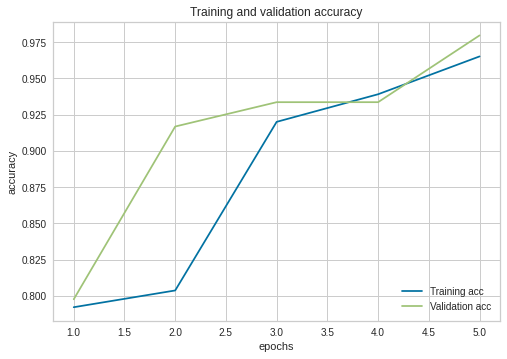

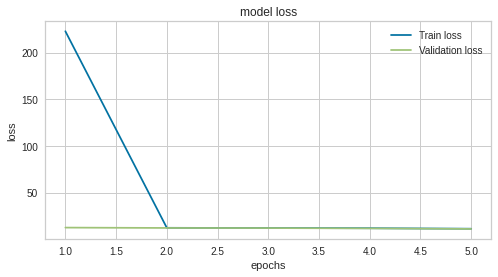

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='lower right')

plt.figure(figsize=(8,4))

plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

plt.show()

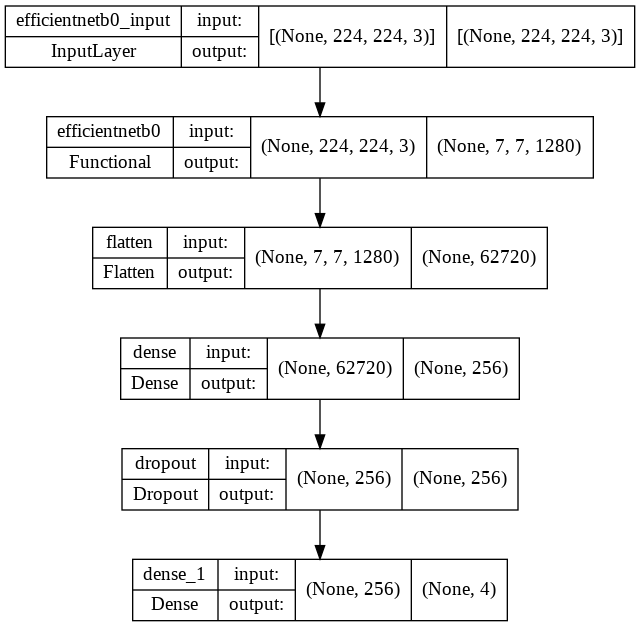

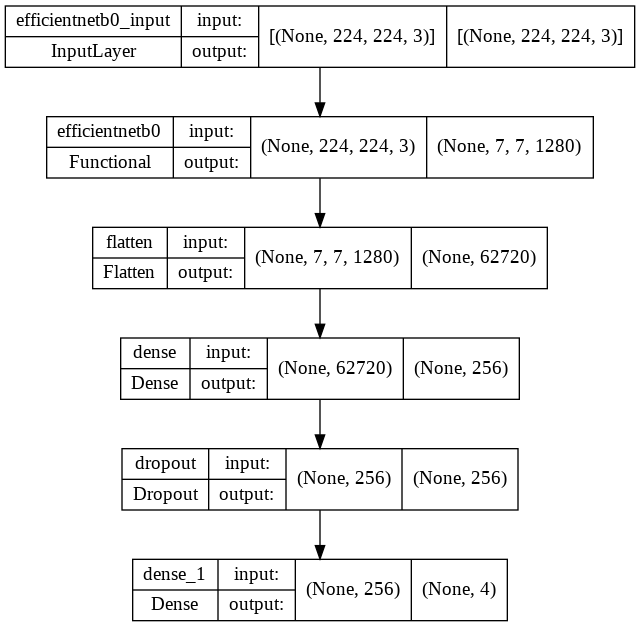

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)